# Gacha System Explained
> Credits to [KokomiClan](https://www.youtube.com/watch?v=gZGW190E3ok) for the wonderful explanation

## How to get 5 star?

We will get a 5 star if we have a random number <= pull rate given by the banner. Random number is generated on the server evenly between 0 and 1. Below is the algorithm:

```py
def get_rate(warp):
    # base rate same until we reach 74th pull
    if warp < 74:
        return 0.06
    
    # after 73th pull, the rate increase 6% per pull until 90 pull
    elif warp < 90 and warp >= 74:
        return (warp - 73) * 0.06 + 0.006
    
    else:
        return 1.00
```

## The Distribution of Successful Pull

### For warp < 74
It is just geometric distribution:

```txt
warp < 74

prob(5_star in X wrap) = 1 - (prob(no 5_star))^warp
             = 1 - (1 - 0.006)^warp

prob(X < 40) = 1 - (1 - 0.006)^40 = 0.2139
```

If we want to know the probability of getting 5-star in the 40 pull:

```txt
prob(X = 40) = prob(X < 40) - prob(X < 39)
```

### For warp >= 74
The rate will change with warp, taking the previous rate into consideration:

```txt
P(X < 74) = P(X < 73) + (1 - P(X < 73)) * get_rate(74)
P(X < 75) = (1 - P(X < 73)) * get_rate_mult(75) * get_rate(75) + P(X < 74)
P(X < 76) = (1 - P(X < 73)) * get_rate_mult(76) * get_rate(76) + P(X < 75) + P(X < 74)

...

```

Recursive rate algorithm:
```py
def get_rate_mult(warp):
    if warp == 75:
        return 1 - get_rate(74)
    
    else:
        return (1 - get_rate(warp - 1)) * get_rate_mult(warp - 1)
```

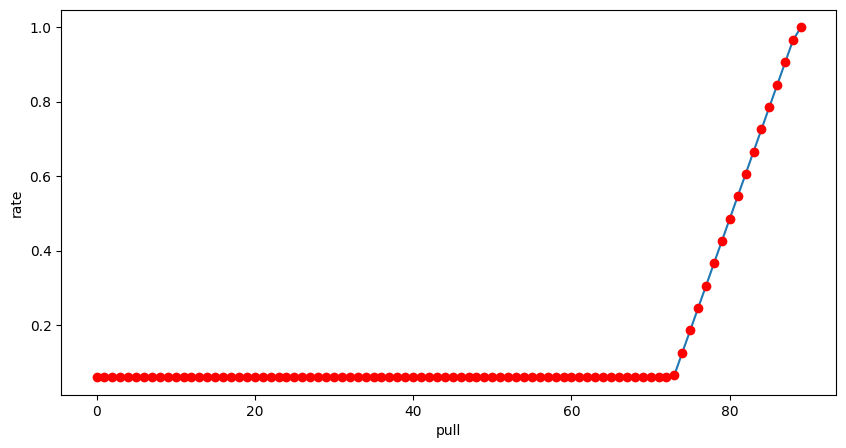

In [16]:
# pull rate graph visualization

# function to get rate
def get_rate(warp):
    # base rate same until we reach 74th pull
    if warp < 74:
        return 0.06
    
    # after 73th pull, the rate increase 6% per pull until 90 pull
    elif warp < 90 and warp >= 74:
        return (warp - 73) * 0.06 + 0.006
    
    else:
        return 1.00

# test
x = []
for i in range(1,91):
    x.append(get_rate(i))
    
# plot
import matplotlib.pyplot as plt
plt.plot(x)
plt.xlabel('pull')
plt.ylabel('rate')
plt.plot(x, 'ro')
plt.show()


We can see that the rate increases significantly after 74 pull which leads us to a higher chance of getting 5 star. 

Average pull for a 5 star including guarantee: 62.311927
Consolidated probability rate: 1.6%


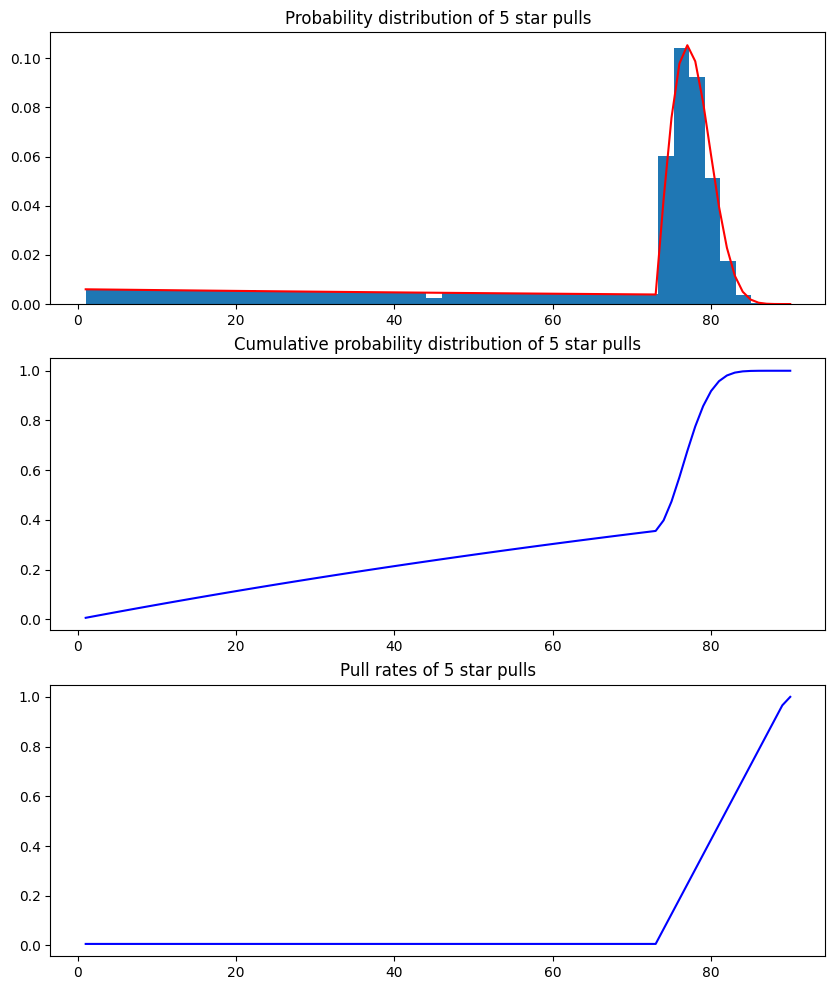

In [18]:
# warp simulation


import numpy as np
from numba import jit
import matplotlib.pyplot as plt
from scipy.stats import geom

# plot setting
plt.rcParams['figure.figsize'] = [10, 12]

N = 1000000


@jit(nopython=True, parallel=True)
def simulate():
    # Pre-allocate the array
    five_star = np.zeros((N,))

    # Simulate random uniform numbers
    random_numbers = np.random.uniform(0, 1, N * 90) # We use N * 90 since hard pity is at 90 pulls, i.e. upper bound

    for i in range(N):
        for j in range(1, 91):
            if random_numbers[i * 90 + j] <= get_rate(j):
                five_star[i] = j
                break

    return five_star


# Define the pull rate function
@jit(nopython=True)
def get_rate(x: float):
    # Normal pulls
    if x < 74:
        return 0.006
    # Soft pity -> Hard Pity Ramp
    elif 74 <= x < 90:
        return (x - 73) * 0.06 + 0.006
    else:
        return 1.0


# For the soft pity, we need to add this to the probabilities - recursive function since it depends on the previous
def get_rate_mult(x: float):
    if x == 75:
        return 1 - get_rate(74)
    else:
        return (1 - get_rate(x - 1)) * get_rate_mult(x - 1)


# Define a probability function
def prob(x, cumulative=False, rate=False):
    # Pre-allocate the array
    output = np.zeros((x.size, ))

    # Cumulative Probabilities above 75 need to be calculated differently using recursion
    plus_75 = [(1 - geom.cdf(73, 0.006)) * get_rate_mult(i) * get_rate(i) for i in range(75, 90)]
    plus_75 = np.cumsum(plus_75) + geom.cdf(73, 0.006) + (1 - geom.cdf(73, 0.006)) * get_rate(74)

    # Calculate cumulative probabilities
    for ii in range(x.size):
        if x[ii] < 74:
        # In simple english: 1 - (1 - 0.006) ^ ii, or 1 - probability of not getting a 5 star in ii pulls
            output[ii] = geom.cdf(x[ii], 0.006)
        elif x[ii] == 74:
            # In simple english: Probability of getting it in 73 pulls, then getting it on the 74th pull which is
            # the rate of getting it multiplied by the probability of not getting it in 73 pulls
            output[ii] = geom.cdf(73, 0.006) + (1 - geom.cdf(73, 0.006)) * get_rate(74)
        elif 75 <= x[ii] < 90:
            # Some recursive magic xD.
            output[ii] = plus_75[int(x[ii]) - 75]
        else:
            output[ii] = 1

        if rate:
            output[ii] = get_rate(x[ii])

    if not cumulative:
        output = np.insert(np.diff(output), 0, 0.006)

    return output



results = simulate()

# Print the output
print("Average pull for a 5 star including guarantee: {}".format(results.mean()))

# Plot the histogram of the results
ax, fig = plt.subplots(3, 1)
plt.subplot(3, 1, 1)
plt.hist(results, bins=45, density='True')

# Get the probability distribution, cumulative distribution and pull rates
x = np.linspace(1, 90, 90, dtype=float)
y_prob = prob(x)
y_cum_prob = prob(x, cumulative=True)
y_rate = [get_rate(x) for x in range(1, 91)]

# Plot the results of probability distribution
plt.plot(x, y_prob, 'r')
plt.title("Probability distribution of 5 star pulls")

# Cumulative rates
plt.subplot(3, 1, 2)
plt.title("Cumulative probability distribution of 5 star pulls")
plt.plot(x, y_cum_prob, 'b')

# Pull rates
plt.subplot(3, 1, 3)
plt.title("Pull rates of 5 star pulls")
plt.plot(x, y_rate, 'b')

# Finally, working out the consolidated probability rate:
print("Consolidated probability rate: {:.2}%".format((1 / (y_prob @ np.arange(1, 91))) * 100))

# Save the output
np.savetxt("data/y_prob.csv", y_prob, delimiter=',')
np.savetxt("data/y_cum_prob.csv", y_cum_prob, delimiter=',')
np.savetxt("data/y_rate.csv", y_rate, delimiter=',')